In [1]:
import sklearn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('data/A_Z Handwritten Data.csv', header=None)
df.sample(5)

,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,784
253689,18,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
356118,24,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
162679,14,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
282930,19,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
64637,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [3]:
df.shape

(372451, 785)

In [4]:
df_frac = df.sample(frac=0.01).reset_index(drop=True)
df_frac.shape

(3725, 785)

In [5]:
sorted(df_frac[0].unique())

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25]

In [11]:
alphabets = 'A B C D E F G H I J K L M N O P Q R S T U V W X Y Z'.split()
LOOKUP = dict(zip(range(26), alphabets))
LOOKUP

{0: 'A',
 1: 'B',
 2: 'C',
 3: 'D',
 4: 'E',
 5: 'F',
 6: 'G',
 7: 'H',
 8: 'I',
 9: 'J',
 10: 'K',
 11: 'L',
 12: 'M',
 13: 'N',
 14: 'O',
 15: 'P',
 16: 'Q',
 17: 'R',
 18: 'S',
 19: 'T',
 20: 'U',
 21: 'V',
 22: 'W',
 23: 'X',
 24: 'Y',
 25: 'Z'}

In [14]:
def display_image(features, actual_label):
    print('Actual label:', LOOKUP[actual_label])
    plt.imshow(features.reshape(28, 28), cmap='gray')
    plt.show();

In [13]:
X = df_frac[df_frac.columns[1:]]
y = df_frac[0]

Actual label: Y


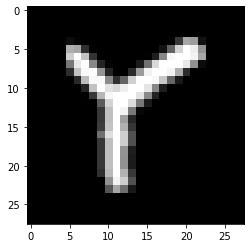

Actual label: Z


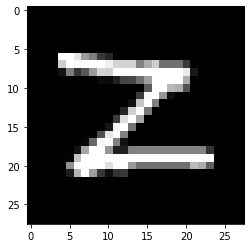

Actual label: N


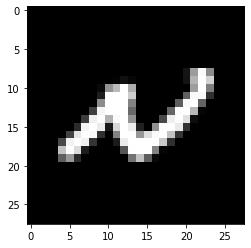

Actual label: T


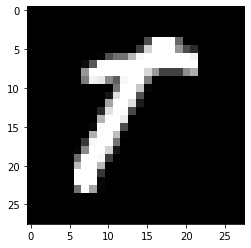

In [17]:
for i in (1, 11, 125, 758):
    display_image(X.loc[i].values, y.loc[i])

In [18]:
X = X / 255.
X -= X.mean(axis=0)

In [20]:
n_samples = X.shape[0]
n_samples

3725

In [22]:
data_train, labels_train = X[:n_samples//2], y[:n_samples//2]
data_test, labels_test = X[n_samples//2:], y[n_samples//2:]
data_train.shape, labels_train.shape, data_test.shape, labels_test.shape

((1862, 784), (1862,), (1863, 784), (1863,))

In [23]:
from time import time
from sklearn import svm, pipeline
from sklearn.kernel_approximation import Nystroem, RBFSampler

In [39]:
kernel_svm = svm.SVC(gamma=.01, kernel='rbf')
linear_svm = svm.LinearSVC(max_iter=1500)
rbf_approx_svm = pipeline.Pipeline([
    ('rbf_sampler', RBFSampler(gamma=0.01, random_state=1, n_components=len(data_train))),
    ('svm', svm.LinearSVC())
])
nystroem_approx_svm = pipeline.Pipeline([
    ('nystroem', Nystroem(gamma=0.01, random_state=1, n_components=len(data_train))),
    ('svm', svm.LinearSVC())
])

In [40]:
estimators = dict(
    linear_svm=linear_svm,
    kernel_svm=kernel_svm,
    rbf_approx_svm=rbf_approx_svm,
    nystroem_approx_svm=nystroem_approx_svm
)

In [41]:
for est_name, estimator in estimators.items():
    t0 = time()
    estimator.fit(data_train, labels_train)
    train_time = time() - t0
    t0 = time()
    score=estimator.score(data_test, labels_test)
    score_time = time() - t0
    print(f'{est_name}\n\tScore: {score:.3f}\n\tTrain time: {train_time:.3f}s\n\tScore time: {score_time:.3f}s')

linear_svm
	Score: 0.697
	Train time: 3.416s
	Score time: 0.008s
kernel_svm
	Score: 0.812
	Train time: 0.724s
	Score time: 1.887s
rbf_approx_svm
	Score: 0.828
	Train time: 3.057s
	Score time: 0.118s
nystroem_approx_svm
	Score: 0.837
	Train time: 6.139s
	Score time: 0.229s


In [42]:
sample_sizes = 300 * np.arange(1, 7)
sample_sizes

array([ 300,  600,  900, 1200, 1500, 1800])

In [43]:
rbf_scores, nystroem_scores, rbf_times, nystroem_times = [], [], [], []

In [44]:
for D in sample_sizes:
    rbf_approx_svm.set_params(rbf_sampler__n_components=D)
    nystroem_approx_svm.set_params(nystroem__n_components=D)
    
    t0 = time()
    rbf_approx_svm.fit(data_train, labels_train)
    rbf_times.append(time() - t0)

    t0 = time()
    nystroem_approx_svm.fit(data_train, labels_train)
    nystroem_times.append(time() - t0)

    rbf_score = rbf_approx_svm.score(data_test, labels_test)
    nystroem_score = nystroem_approx_svm.score(data_test, labels_test)

    rbf_scores.append(rbf_score)
    nystroem_scores.append(nystroem_score)

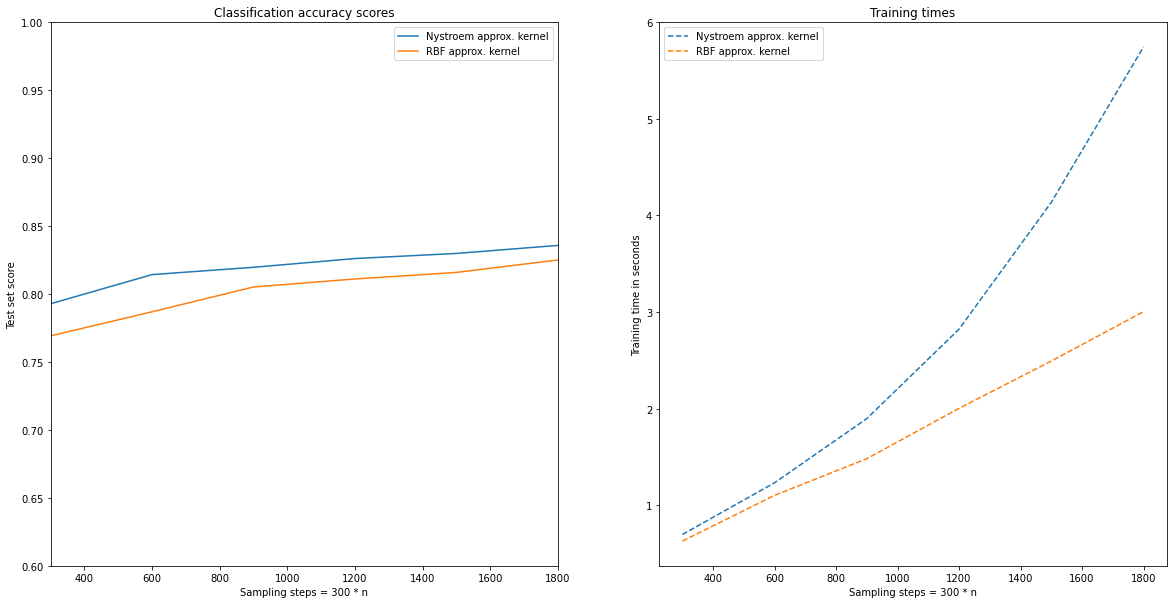

In [45]:
plt.figure(figsize=(20, 10))

accuracy = plt.subplot(121)
timescale = plt.subplot(122)

accuracy.plot(sample_sizes, nystroem_scores, label='Nystroem approx. kernel')
timescale.plot(sample_sizes, nystroem_times, '--', label='Nystroem approx. kernel')

accuracy.plot(sample_sizes, rbf_scores, label='RBF approx. kernel')
timescale.plot(sample_sizes, rbf_times, '--', label='RBF approx. kernel')

accuracy.set_xlabel('Sampling steps = 300 * n')
accuracy.set_ylabel('Test set score')

timescale.set_xlabel('Sampling steps = 300 * n')
timescale.set_ylabel('Training time in seconds')

accuracy.set_title('Classification accuracy scores')
timescale.set_title('Training times')

accuracy.set_xlim(sample_sizes[0], sample_sizes[-1])
accuracy.set_ylim(0.6, 1)

accuracy.legend(loc='best')
timescale.legend(loc='best')

plt.show();